In [1]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt

# from lithium.Lithium_Properties_2D_750G import m_Li6

# Data Loading and Definition of Variables

In [66]:
# path to images
images_set = "B-T4_hot"

path_dir = "Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/" + images_set + "/"
path_file = os.listdir(path_dir)

In [67]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [68]:
variables

['i']

In [69]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [70]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 9.05 ms


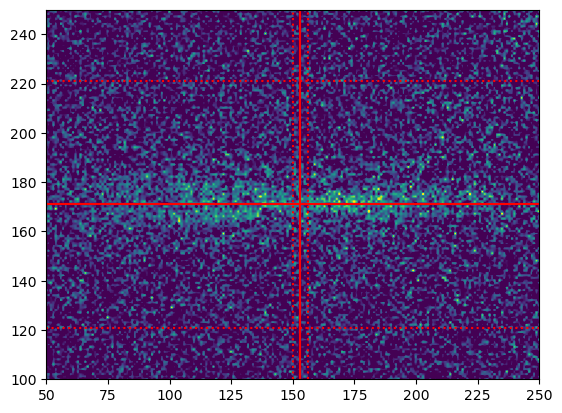

In [72]:
# determine optimal ROI
center = (171, 153)
h = 50
w = 3

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [73]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 8/8 [100%] in 1.1s (6.50/s)          
CPU times: total: 469 ms
Wall time: 1.15 s


In [74]:
var_vals[0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

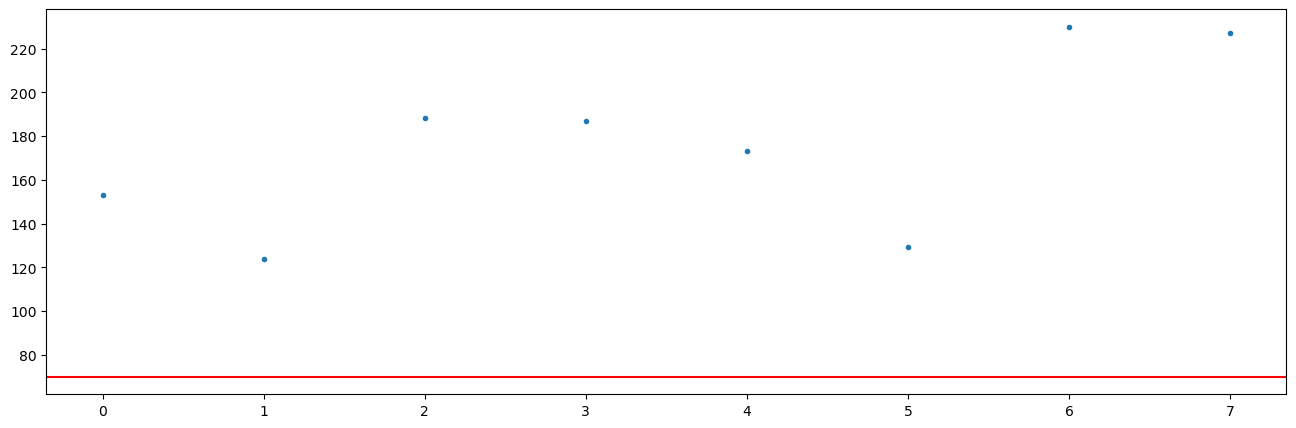

In [75]:
# filter out missed shots
bol = []

for rate in var_vals[0]:

    for i, im in images_prc[images_prc["i"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(70, c = "r")

plt.ylim(None, None)

plt.show()

In [76]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 70)

CPU times: total: 93.8 ms
Wall time: 95.4 ms


In [77]:
# plt.imshow((images_fil.iloc[0]["density"] +
#             images_fil.iloc[1]["density"] +
#             images_fil.iloc[2]["density"] +
#             images_fil.iloc[3]["density"] +
#             images_fil.iloc[4]["density"] +
#             images_fil.iloc[5]["density"] +
#             images_fil.iloc[6]["density"] +
#             images_fil.iloc[7]["density"])/8, vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [78]:
# plt.imshow(images_fil["density"].mean(numeric_only = False), vmin = 0, vmax = 3, cmap = "viridis")
#
# plt.xlim(125, 175)
# plt.ylim(100, 250)
#
# plt.show()

In [79]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i")

CPU times: total: 15.6 ms
Wall time: 19.9 ms


In [80]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 0 ns
Wall time: 14 ms


In [81]:
%%time
# calculate response
# images_res = la.response(images_fit)

CPU times: total: 0 ns
Wall time: 0 ns


# Visualization

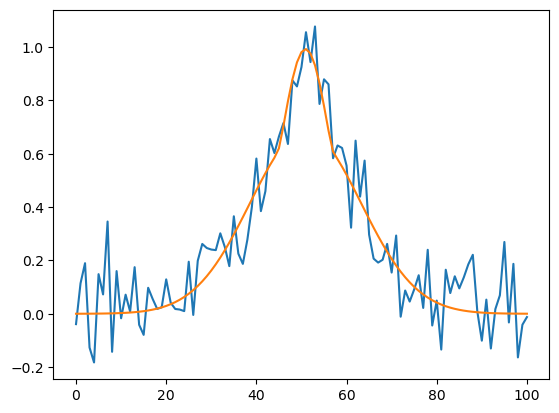

[7.935882680445127, 0.9931412219167481]


In [82]:
field = 0

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

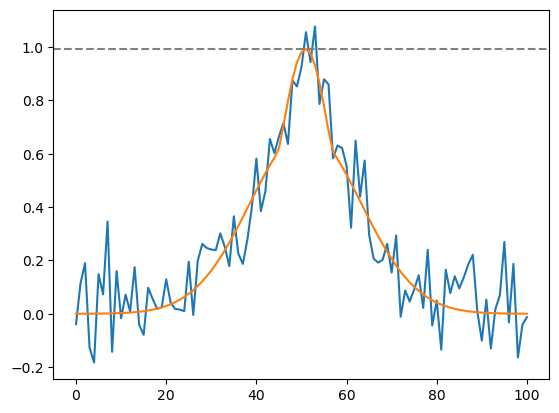

Temperature 7.94 +- 0.99 nK
[6.84654868e-01 5.14084048e+01 3.09581639e+02 3.08373363e-01
 6.28910659e+00]



In [83]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
                                                              im["T4_params"][1],
                                                              im["T4_params"][2],
                                                              im["T4_params"][3],
                                                              im["T4_params"][4],))

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")

    plt.show()

    # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
    print(im["T4_params"])
    print("")

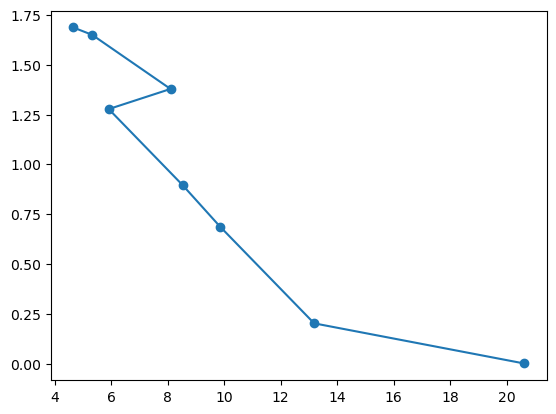

In [65]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


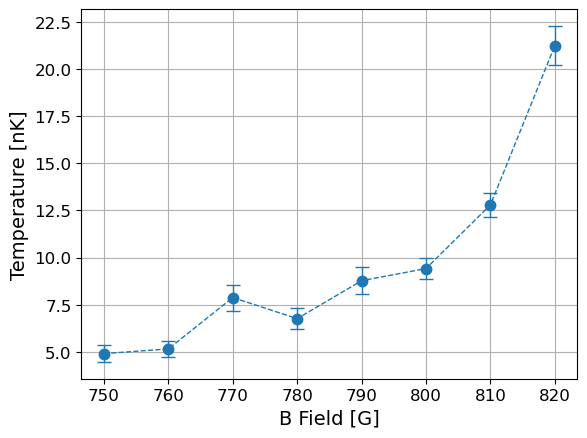

In [17]:
B = np.array(images_fit["FB_Img"].tolist())
T = np.array(images_fit["temperature"].tolist())

plt.errorbar(B, T[:, 0], T[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel("B Field [G]", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()

In [28]:
omega_T4 = 2 * const.pi * 27.3 # angular frequency of T4 harmonic [Hz]
m_Li = 9.9883414e-27           # mass of lithium [kg]
px_to_x = 1.09739368998628e-6  # effective pixel size in [m]

TTT = 300 * px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9

sigma = 30 * (px_to_x**2 * m_Li * omega_T4**2 / const.k * 1e9)**(-1)

# print(TTT)
print(sigma)

1170.3107955320947
